In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
folder_conversation = os.path.dirname(os.path.abspath("")) + "\\py311_pckg\\conversation\\historique"

# conversation_paths are all csv files in folder_conversation
conversation_paths = [os.path.join(folder_conversation, f) for f in os.listdir(folder_conversation) if f.endswith('.csv')]

print(len(conversation_paths))

126


In [3]:
list_df = [pd.read_csv(f) for f in conversation_paths]

In [4]:
# get the column names
column_names = list_df[0].columns
print("; ".join(column_names))

modelname; timestamp; username; usertype; messages_content; prompt_latency; response_latency; save_latency


In [5]:
# add the column "nb_words" and "nb_chars" to each dataframe
for df in list_df:
    df["messages_content"] = df["messages_content"].astype(str)
    df["modelname"] = df["modelname"].astype(str)
    df["nb_words"] = df["messages_content"].apply(lambda x: len(x.split())).astype(float)
    df["nb_chars"] = df["messages_content"].apply(lambda x: len(x)).astype(float)

non-human generated responses:  1232
human generated responses:  402


C:\Users\echriston\AppData\Local\Temp\ipykernel_44860\3123561009.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_df = pd.concat(list_df, ignore_index=True)


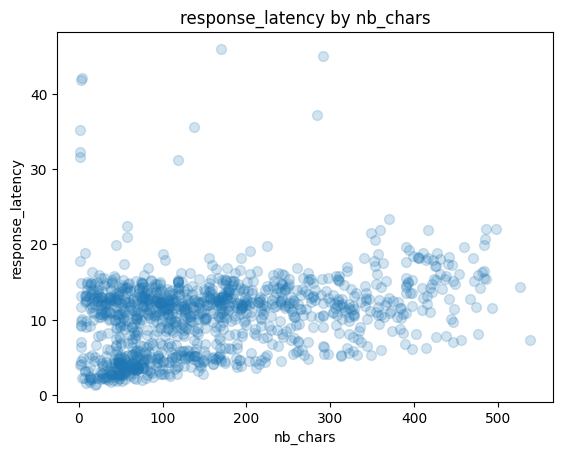

In [6]:
# plot the number of caaracters by response_latency when usertype doesn't contain "Human"
# first concatenate all the dataframes

all_df = pd.concat(list_df, ignore_index=True)

# plot the number of characters by response_latency when usertype doesn't contain "Human"
all_df_no_human = all_df[all_df["usertype"] != "HumanSpeaker"]
all_df_no_human = all_df_no_human[all_df_no_human["usertype"] != "HumanWriter"]

print("non-human generated responses: ", len(all_df_no_human))
print("human generated responses: ", len(all_df) - len(all_df_no_human))

fig, ax = plt.subplots()
ax.scatter(all_df_no_human["nb_chars"], all_df_no_human["response_latency"], alpha=0.2, s=50)
ax.set_xlabel("nb_chars")
ax.set_ylabel("response_latency")
ax.set_title("response_latency by nb_chars")
plt.show()

C:\Users\echriston\AppData\Local\Temp\ipykernel_44860\2247206633.py:39: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(features, axis=0), color=color, linewidth=3, label=modelname[:15] + " " + modelname[-11:-5], alpha=0.6)
C:\Users\echriston\AppData\Local\Temp\ipykernel_44860\2247206633.py:46: RuntimeWarning: Mean of empty slice
  ax.set_ylim(0, 1.1 * np.nanmax(np.nanmean(features, axis=0)))


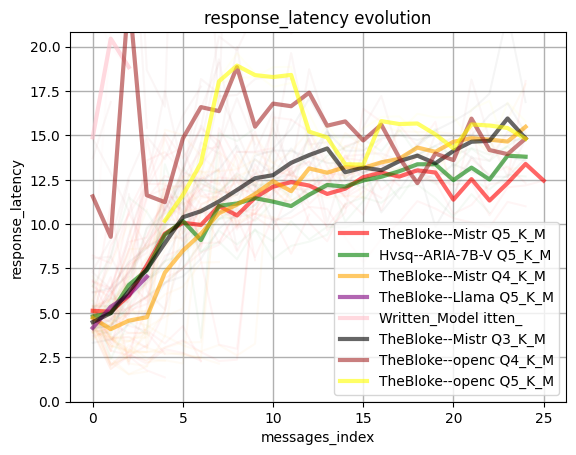

In [7]:
def plot_feature_evolution_per_model(feature_name:str="response_latency", only_non_human:bool=False):
    """plot the feature evolution for each conversation"""

    fig, ax = plt.subplots()

    COLORS = ["blue", "red", "green", "orange", "purple", "pink", "black", "brown", "yellow", "grey"]

    for modelname in all_df["modelname"].unique():

        color = COLORS.pop(0)
        features = []

        for df in list_df:

            df = df[df["modelname"] == modelname]

            if only_non_human:
                df = df[df["usertype"] != "HumanSpeaker"]
                df = df[df["usertype"] != "HumanWriter"]
            
            if len(df) == 0:
                continue

            # reset the index
            df = df.reset_index()

            ax.plot(df.index, df[feature_name], alpha=0.04, color=color)
            # store the feature per index
            features.append(df[feature_name].values)

        if len(features) == 0:
            continue

        # make fetaures a numpy array table with the same number of columns
        max_len = max([len(l) for l in features])
        features = np.array([np.pad(lat, (0, max_len - len(lat)), 'constant', constant_values=np.nan) for lat in features])

        # plot the mean feature of non-nan features
        ax.plot(np.nanmean(features, axis=0), color=color, linewidth=3, label=modelname[:15] + " " + modelname[-11:-5], alpha=0.6)

    ax.set_xlabel("messages_index")
    ax.set_ylabel(feature_name)
    ax.set_title(feature_name + " evolution")
    ax.legend()

    ax.set_ylim(0, 1.1 * np.nanmax(np.nanmean(features, axis=0)))

    # minor grid on the y axis
    ax.yaxis.grid(True, which='minor', linestyle='--', linewidth=0.5)

    # major grid on both axis
    ax.grid(True, which='major', linestyle='-', linewidth=1)

    plt.show()


plot_feature_evolution_per_model("response_latency", only_non_human=True)

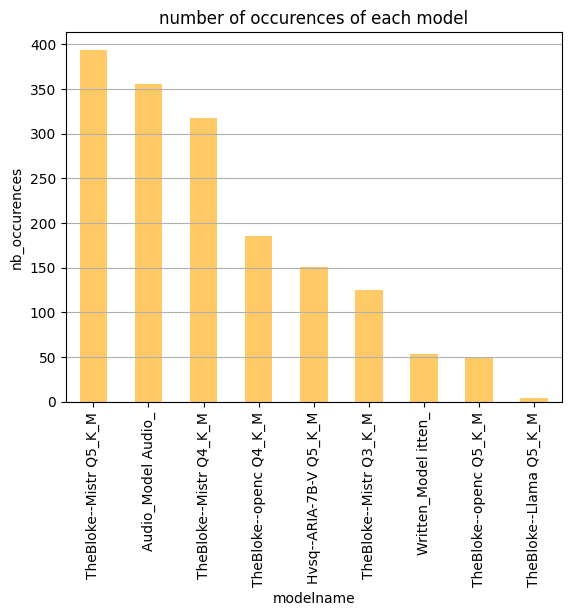

In [8]:
# build short model column
all_df["short_modelnames"] = all_df["modelname"].apply(lambda x: x[:15] + " " + x[-11:-5])



# make a plot bar with the number of occurences of each model
fig, ax = plt.subplots()
all_df["short_modelnames"].value_counts().plot(kind="bar", ax=ax, color="orange", alpha=0.6)

ax.set_xlabel("modelname")
ax.set_ylabel("nb_occurences")
ax.set_title("number of occurences of each model")
ax.grid(axis="y")
plt.show()